In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install hyperas
!pip install hyperopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 120 kB 5.1 MB/s 
     |████████████████████████████████| 1.6 MB 30.9 MB/s 
     |████████████████████████████████| 82 kB 650 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from __future__ import print_function
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform
from keras.utils import np_utils

In [5]:
# conda update keras

In [6]:
# permetrics 사용을 위한 코드 (conda install permetrics : package not found error)
!pip install git+https://github.com/thieu1995/permetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/thieu1995/permetrics to /tmp/pip-req-build-p721zjck
  Running command git clone -q https://github.com/thieu1995/permetrics /tmp/pip-req-build-p721zjck
  Created wheel for permetrics: filename=permetrics-1.3.0-py3-none-any.whl size=26351 sha256=bbfb816538447d264e6cfa9bf717882ee5e9bd77b946cd7e0d4ee0de21b6fefd
  Stored in directory: /tmp/pip-ephem-wheel-cache-rol60apx/wheels/e9/84/08/e76f6bf9b2ae02dbf0bbeb51d2fe300d87c7c8bb2d4443953c
Successfully built permetrics


In [42]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

import time
from glob import glob
from tqdm import tqdm
from permetrics.regression import RegressionMetric

import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras import backend as K
# from keras.utils import plot_model

from keras.layers import Activation, Dense, LSTM, GRU, Bidirectional, AveragePooling1D, GlobalAveragePooling1D, Dropout, Flatten, BatchNormalization, TimeDistributed, Input, Reshape, RepeatVector, Concatenate, GlobalMaxPooling1D 
from keras.layers import Conv1D


#GPU 자원이 부족
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import os
os.chdir('/content/drive/MyDrive/신입기수 프로젝트/Dataset')

In [10]:
# Install the PyDrive wrapper & import libraries.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

## 데이터 불러오기, 공통 전처리

In [8]:
raw_data = pd.read_csv('newdata5.csv', encoding = 'cp949')
# for jupyterpd.pd
# /Volumes/GoogleDrive/.shortcut-targets-by-id/1rUx7_7LmBqAQTbWEWVTGvw0_d0v6N2ZT/신입기수 프로젝트/Dataset/newdata5.csv

# 마지막 수위 부분 저장을 위한 copy본 만들어두기
raw_data_copy = raw_data.copy()

# 강수량 버리기
raw_data = raw_data.drop(columns = ['서울시_강수량'], axis = 1)

# 단변량으로 결측치 처리한 강화대교 조위 파일 가져오기
광진교_수위 = pd.read_csv('cnn_광진.csv', encoding = 'UTF-8')['수위']

# for jupyter
# 행주대교_유량 = pd.read_csv('/Volumes/GoogleDrive/.shortcut-targets-by-id/1rUx7_7LmBqAQTbWEWVTGvw0_d0v6N2ZT/신입기수 프로젝트/Dataset/CNN_전처리/행주대교_유량_2nd.csv', encoding = 'cp949')
# 행주대교_수위 = pd.read_csv('/Volumes/GoogleDrive/.shortcut-targets-by-id/1rUx7_7LmBqAQTbWEWVTGvw0_d0v6N2ZT/신입기수 프로젝트/Dataset/CNN_전처리/행주대교_수위_6th.csv', encoding = 'cp949')
# 한강대교_수위 = pd.read_csv('/Volumes/GoogleDrive/.shortcut-targets-by-id/1rUx7_7LmBqAQTbWEWVTGvw0_d0v6N2ZT/신입기수 프로젝트/Dataset/CNN_전처리/한강대교_수위.csv', encoding = 'cp949')
# 잠수교_수위 = pd.read_csv('/Volumes/GoogleDrive/.shortcut-targets-by-id/1rUx7_7LmBqAQTbWEWVTGvw0_d0v6N2ZT/신입기수 프로젝트/Dataset/CNN_전처리/잠수교_수위.csv', encoding = 'cp949')
# 청담대교_수위 = pd.read_csv('/Volumes/GoogleDrive/.shortcut-targets-by-id/1rUx7_7LmBqAQTbWEWVTGvw0_d0v6N2ZT/신입기수 프로젝트/Dataset/CNN_전처리/청담대교_수위.csv', encoding = 'cp949')

# raw_data에 REPLACE
raw_data['광진교_수위'] = 광진교_수위

# 날짜를 index로 바꾸고 dtype을 datetime으로 바꾸기
raw_data.set_index(keys = ['날짜'], inplace = True)
raw_data.index = pd.to_datetime(raw_data.index, format = '%Y-%m-%d %H:%M')

# x y 나누기
input_y = raw_data[['청담대교_수위','잠수교_수위','한강대교_수위','행주대교_수위']]
input_x = raw_data

# 정규화
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

input_x_regular = input_x.copy()

for i in range(len(input_x.columns)):
    scaler = MinMaxScaler()                       #StandardScaler() , MinMaxScaler() , RobustScaler()
    a=np.array(input_x_regular.iloc[:,i])
    tmp_x = scaler.fit_transform(a.reshape(-1,1))
    input_x_regular.iloc[:,i] = tmp_x

input_regular = pd.concat([input_x_regular, input_y], axis = 1)
input_regular

,대곡교_강수량,진관교_강수량,송정동_강수량,방류량,강화대교_조위,청담대교_유량,한강대교_유량,행주대교_유량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위,광진교_수위,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
날짜,,,,,,,,,,,,,,,,,
2012-05-01 00:00:00,0.0,0.0,0.0,0.058462,0.191781,0.024640,0.147596,0.011070,0.049611,0.060000,0.051621,0.056478,0.056452,310.7,300.2,290.0,275.3
2012-05-01 00:10:00,0.0,0.0,0.0,0.058447,0.199253,0.027800,0.147654,0.011070,0.053502,0.060000,0.051621,0.056478,0.056452,314.7,300.2,290.0,275.3
2012-05-01 00:20:00,0.0,0.0,0.0,0.057689,0.209215,0.027001,0.147478,0.011070,0.052529,0.061111,0.051621,0.056478,0.056452,313.7,301.2,290.0,275.3
2012-05-01 00:30:00,0.0,0.0,0.0,0.058462,0.219178,0.025421,0.147478,0.011475,0.050584,0.061111,0.051621,0.058140,0.056452,311.7,301.2,290.0,276.3
2012-05-01 00:40:00,0.0,0.0,0.0,0.058451,0.232877,0.025421,0.146810,0.011883,0.050584,0.061111,0.052821,0.059801,0.056452,311.7,301.2,291.0,277.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-18 23:10:00,0.0,0.0,0.0,0.046624,0.458281,0.008355,0.106425,0.025719,0.027529,0.054222,0.062425,0.107475,0.045699,288.0,295.0,299.0,306.0
2022-07-18 23:20:00,0.0,0.0,0.0,0.046621,0.488169,0.007719,0.097370,0.026815,0.026556,0.063111,0.068427,0.110797,0.045699,287.0,303.0,304.0,308.0
2022-07-18 23:30:00,0.0,0.0,0.0,0.046620,0.515567,0.015745,0.092994,0.027929,0.038230,0.067556,0.074430,0.114120,0.045699,299.0,307.0,309.0,310.0


## train / test data 생성

In [9]:
xdata = []
ydata = []
xdata_idx = []
ydata_idx = [-4,-3,-2,-1]
for i in range(len(input_regular.columns)-4):
    xdata_idx.append(i)

w =  6 #window size

idx = []
for i in range(12):
  idx.append(i*26496)

for i in tqdm(range(11)):
    if i != 10:
        tmp = input_regular[idx[i]:idx[i+1]]
    else:
        tmp = input_regular[idx[i]:]

    for j in range(len(tmp)-w):
        xdata.append(np.array(tmp.iloc[j:j + w, xdata_idx]).astype(float))

    for j in range(w,len(tmp)):
        ydata.append(np.array(tmp.iloc[j, ydata_idx]).astype(float))

100%|██████████| 11/11 [03:21<00:00, 18.30s/it]


In [11]:
xdata_ = np.array(xdata)
ydata_ = np.array(ydata)

xtrain = xdata_[:-6912]
ytrain = ydata_[:-6912]
xtest = xdata_[-6912:]
#ytest = ydata_[-6912:]

ytest_list = sorted(glob("submission 임시/*.csv"))
ytest = []
# for jupyter
# /Volumes/GoogleDrive/.shortcut-targets-by-id/1rUx7_7LmBqAQTbWEWVTGvw0_d0v6N2ZT/신입기수 프로젝트/Dataset/submission 임시/*.csv

for i in range(len(ytest_list)):
  tmp = pd.read_csv(ytest_list[i], encoding = 'cp949')
  ytest.append(np.array(tmp.iloc[:,1])*100)
    
ytest_ = ytest
ytest = np.array(ytest).T



In [12]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(269358, 6, 13)
(269358, 4)
(6912, 6, 13)
(6912, 4)


In [13]:
# hyperas 사용
def data():
  return xtrain, ytrain, xtest, ytest

## 모델 정의

In [39]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def nse(y_true, y_pred):
    return (1-(K.sum((y_pred-y_true)**2)/K.sum((y_true-K.mean(y_true))**2)))


if 'model_enc_dec_cnn' in locals(): 
    del model_enc_dec_cnn 
if 'history' in locals():
    del history

# hyperas 사용
def model(xtrain, ytrain, xtest, ytest):
  # 모델 쌓기
  model_enc_dec_cnn = Sequential()
  model_enc_dec_cnn.add(Conv1D(filters={{choice([16,32])}}, kernel_size={{choice([2, 3])}}, padding = 'causal', activation='relu', input_shape=(w, xtrain.shape[2])))
  model_enc_dec_cnn.add(Flatten())
  model_enc_dec_cnn.add(RepeatVector(1))
  model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
  model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
  if {{choice(['three', 'four'])}} == 'four':
    model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
  model_enc_dec_cnn.add(LSTM(200, activation='relu'))
  model_enc_dec_cnn.add(Dense(100, activation='relu'))
  model_enc_dec_cnn.add(Dense(4))

  #compile
  optimizer = tf.keras.optimizers.Adam(lr=0.005) #기본값 0.001
  model_enc_dec_cnn.compile(loss=root_mean_squared_error, optimizer=optimizer, metrics =[nse])

  model_enc_dec_cnn.summary()

  #fit을 위한 환경 정의
  epochs = 100
  batch_size = xtrain.shape[0] // 1000
  validation = 0.2

  # checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', save_weights_only=False, monitor='val_loss',mode='min', save_best_only=True)
  early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=5, mode='min')
  rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min', patience=2, min_lr=0.0000001)

  #fit
  model_enc_dec_cnn.fit(xtrain, ytrain, 
                                verbose=1, 
                                epochs=epochs, 
                                batch_size=batch_size, 
                                validation_split=validation,
                                callbacks=[early_stopping_callback, rlrop_callback])
  
  #evaluate
  # keras_model_best = keras.models.load_model('best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error, 'nse': nse})
  score, accuracy = keras_model_best.evaluate(xtest,ytest)
  print("test accuracy: ", accuracy)
  return {'loss': -accuracy, 'status': STATUS_OK, 'model': model_enc_dec_cnn }


In [40]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Copy/download the file
fid = drive.ListFile({'q':"title='HyperasOnColabExample.ipynb'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('HyperasOnColabExample.ipynb')

In [41]:
best_run, best_model = optim.minimize(model=model,
                                          data=data,
                                          max_evals=100,
                                          algo=tpe.suggest,
                                          notebook_name='HyperasOnColabExample', # This is important!
                                          trials=Trials())

>>> Imports:
#coding=utf-8

from __future__ import print_function

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from hyperas.distributions import choice, uniform
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers.core import Dense, Dropout, Activation
except:
    pass

try:
    from keras.datasets import mnist
except:
    pass

try:
    from keras.utils import np_utils
except:
    pass

try:
    from pydrive.auth import GoogleAuth
except:
    pass

try:
    from pydrive.drive import GoogleDrive
except:
    pass

try:
    from google.colab import auth
except:
    pass

try:
    from oauth2client.client import GoogleCredentials
except:
    pass

>>> Hyperas search space:

def get_space():
    return {
        'filters': hp.choice('filters', [16,32]),
        'kernel_size': hp.choice('kernel_size', [2, 3]),
        'kernel_size_1': hp.choice('ker

NameError: ignored

In [ ]:
# yhat = keras_model_best.predict(xtest, verbose=1)

## 학습

In [ ]:
history = model_enc_dec_cnn.fit(xtrain, ytrain, verbose=1, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])

Epoch 1/100
802/802 [==============================] - 66s 75ms/step - loss: 32.5278 - nse: 0.1483 - val_loss: 23.5016 - val_nse: -0.4294 - lr: 0.0050
Epoch 2/100
802/802 [==============================] - 59s 74ms/step - loss: 18.6138 - nse: 0.8662 - val_loss: 10.1834 - val_nse: 0.7027 - lr: 0.0050
Epoch 3/100
802/802 [==============================] - 63s 78ms/step - loss: 15.8596 - nse: 0.9005 - val_loss: 27.2796 - val_nse: -1.4272 - lr: 0.0050
Epoch 4/100
802/802 [==============================] - 59s 73ms/step - loss: 13.6257 - nse: 0.9275 - val_loss: 25.8778 - val_nse: -0.7623 - lr: 0.0050
Epoch 5/100
802/802 [==============================] - 59s 74ms/step - loss: 11.0810 - nse: 0.9534 - val_loss: 19.6514 - val_nse: -0.3998 - lr: 0.0050
Epoch 6/100
802/802 [==============================] - 60s 74ms/step - loss: 7.4204 - nse: 0.9792 - val_loss: 9.1912 - val_nse: 0.7434 - lr: 0.0025
Epoch 7/100
802/802 [==============================] - 64s 79ms/step - loss: 6.7858 - nse: 0.9822 

## 평가

In [ ]:
keras_model_best = keras.models.load_model('best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error, 'nse': nse})

yhat = keras_model_best.predict(xtest, verbose=1)

keras_model_best.evaluate(xtest,ytest)

216/216 [==============================] - 2s 7ms/step - loss: 1.9377 - nse: 0.9700


[1.9377089738845825, 0.9700080752372742]

## 학습 과정 시각화

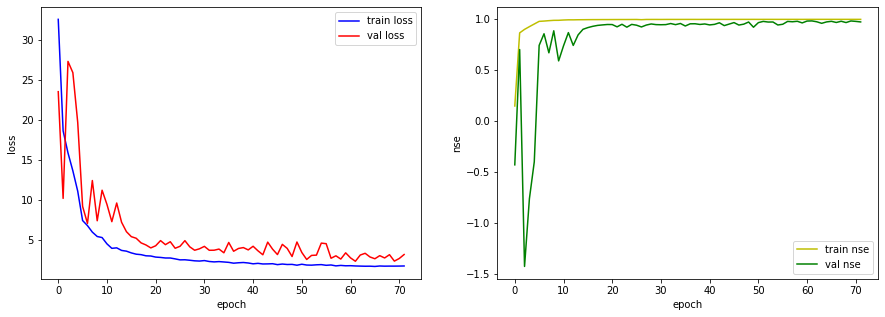

In [ ]:
fig, loss_ax = plt.subplots(1, 2)
fig.set_size_inches((15,5))

loss_ax[0].plot(history.history['loss'], 'b', label='train loss')
loss_ax[0].plot(history.history['val_loss'], 'r', label='val loss')

loss_ax[1].plot(history.history['nse'], 'y', label='train nse')
loss_ax[1].plot(history.history['val_nse'], 'g', label='val nse')

loss_ax[0].set_xlabel('epoch')
loss_ax[0].set_ylabel('loss')
loss_ax[1].set_xlabel('epoch')
loss_ax[1].set_ylabel('nse')

loss_ax[0].legend(loc='upper right')
loss_ax[1].legend(loc='lower right')

plt.show()

## 결과 시각화

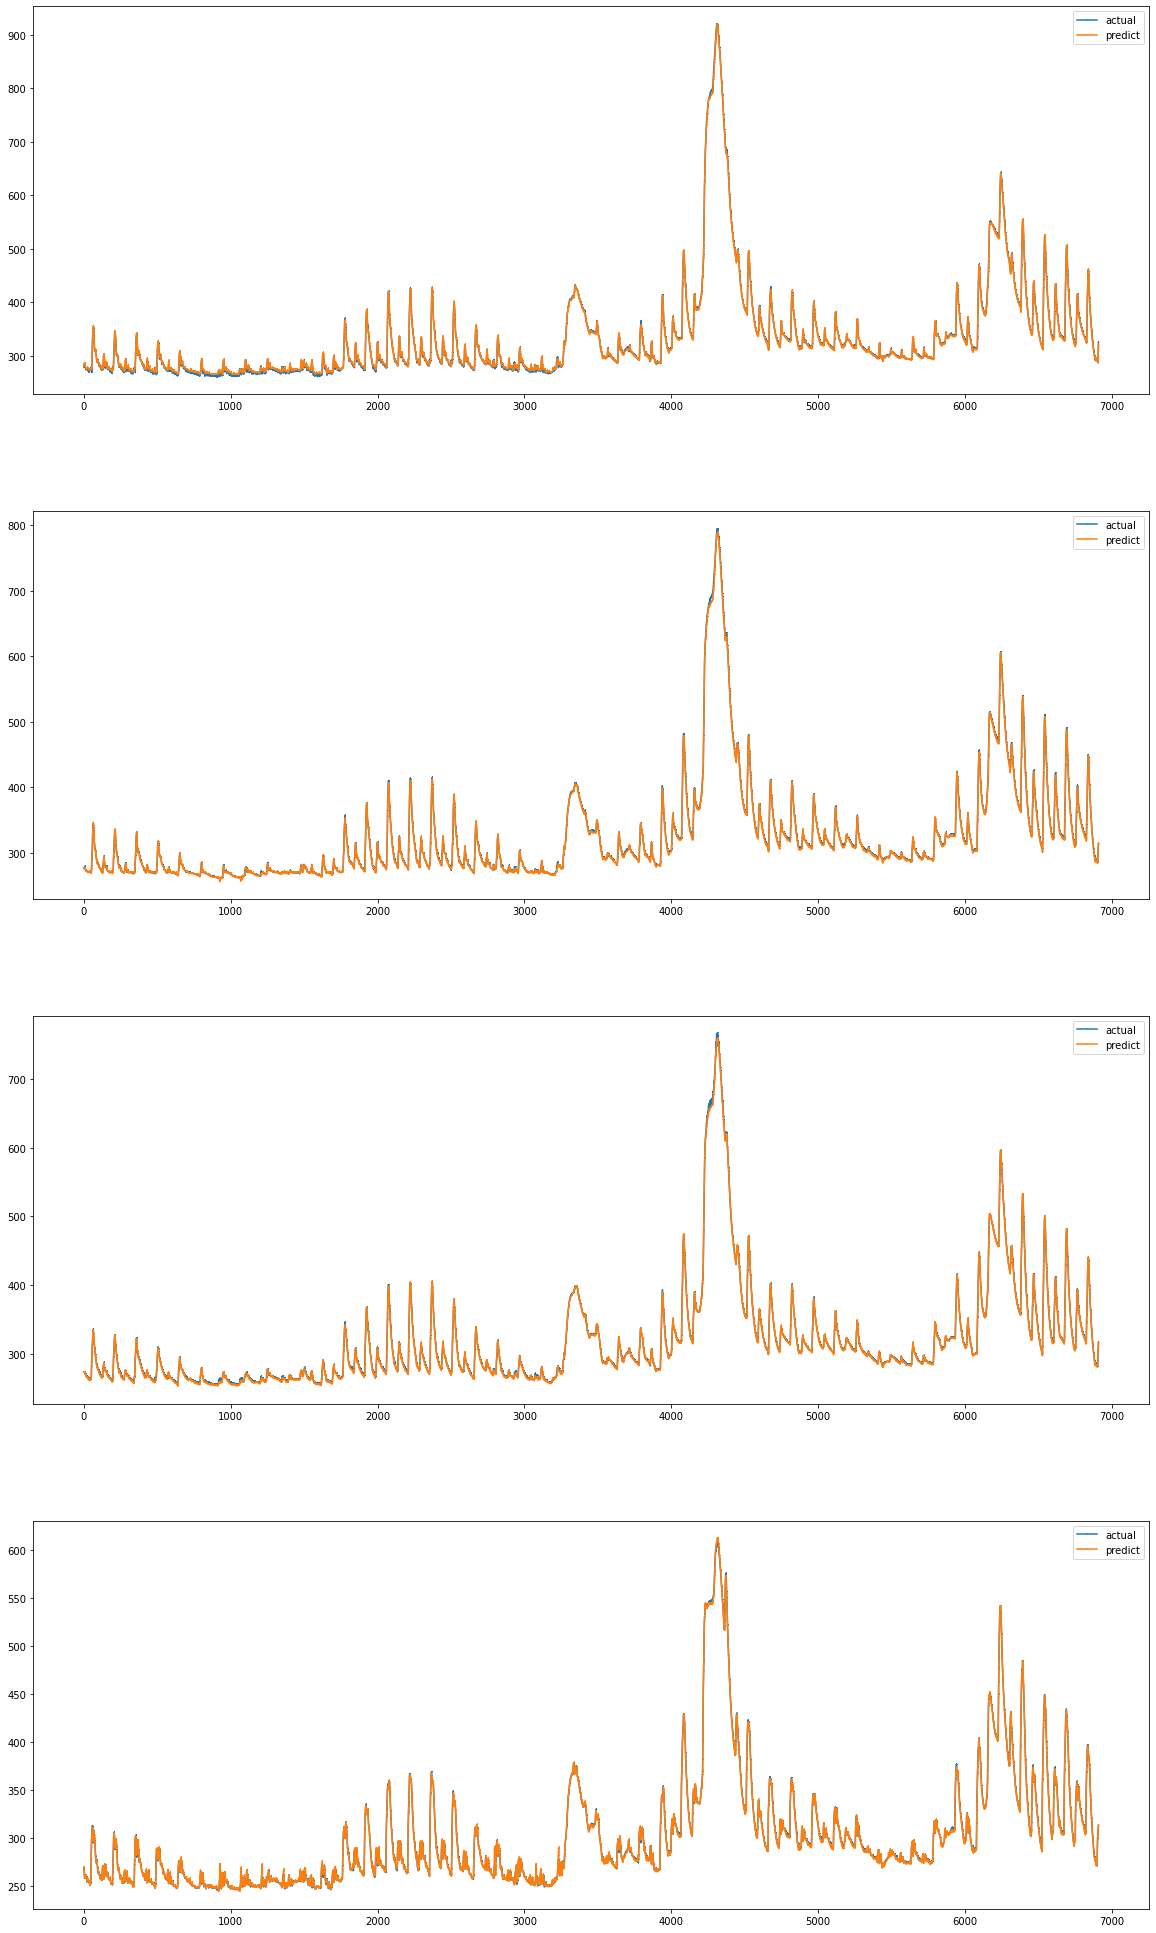

In [ ]:
tl_predict = np.array(yhat).T

#결과 시각화
f, axes = plt.subplots(4, 1)
f.set_size_inches((20, 35))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

for i in range(4):
    axes[i].plot(ytest_[i], marker = ",", label = "actual")
    axes[i].plot(tl_predict[i], marker = ",", label="predict")
    axes[i].legend(prop={'size':10})  

plt.show()

## 점수 확인

In [ ]:
score = []
for i in range(4):
    print(root_mean_squared_error(ytest_[i], tl_predict[i]))
    score.append(root_mean_squared_error(ytest_[i], tl_predict[i]))
    
print("최종점수: ", np.mean(score))

tf.Tensor(2.5987461977202315, shape=(), dtype=float64)
tf.Tensor(2.074484554918349, shape=(), dtype=float64)
tf.Tensor(1.877451426985318, shape=(), dtype=float64)
tf.Tensor(1.7964253232076848, shape=(), dtype=float64)
최종점수:  2.086776875707896


## 점수 확인

In [ ]:
sample_submission = pd.read_csv("Copy of sample_submission.csv")
# for jupyter
# /Volumes/GoogleDrive/.shortcut-targets-by-id/1rUx7_7LmBqAQTbWEWVTGvw0_d0v6N2ZT/신입기수 프로젝트/DACON/competition_data/sample_submission.csv


sample_submission["wl_1018662"] = tl_predict[0]
sample_submission["wl_1018680"] = tl_predict[1]
sample_submission["wl_1018683"] = tl_predict[2]
sample_submission["wl_1019630"] = tl_predict[3]

sample_submission.to_csv("다영_0826_CNN_LSTM/광진교_수위.csv", index = False)